## Dataset - UrbanSound
https://drive.google.com/drive/folders/0By0bAi7hOBAFUHVXd1JCN3MwTEU

In [1]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Project Specific Libraries

import os
import librosa
import librosa.display
import glob 
import skimage

In [3]:
df = pd.read_csv('data/UrbanSound8K/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
dat1, sampling_rate1 = librosa.load('data/UrbanSound8K/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('data/UrbanSound8K/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

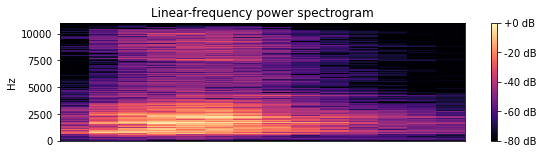

In [6]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

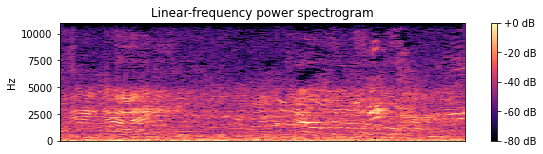

In [7]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

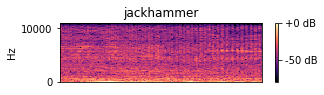

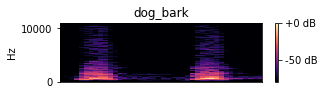

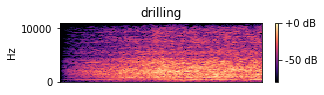

In [16]:
'''Using random samples to observe difference in waveforms.'''

arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = 'data/UrbanSound8K/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

## Feature Extraction and Database Building


In [17]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(50):
        file_name = 'data/UrbanSound8K/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [18]:
temp = parser(df)

In [19]:
temp = np.array(temp)
data = temp.transpose()

<ipython-input-19-16088c198d1d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(temp)


In [20]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([50, 128])

(50,) (50,)


In [21]:
for i in range(50):
    X[i] = (X_[i])

In [131]:
# Y = to_categorical(Y)
Y = np.array(Y.astype(int))

In [132]:
'''Final Data'''
print(X.shape)
print(Y.shape)

(50, 128)
(50,)


In [162]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)
X_train = X_train.reshape(37, 16, 8, 1)
X_test = X_test.reshape(13, 16, 8, 1)

In [163]:
from torchvision import datasets, transforms, models
import torch
from torch import nn


In [164]:
model = models.resnet18(pretrained=True)

In [165]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [166]:
vgg16 = models.vgg16(pretrained=True)
# Freeze VGG weights
for param in vgg16.parameters():
    param.requires_grad = False

In [167]:
classifier = nn.Sequential(
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, len(df.classID.unique())),
        nn.Softmax(dim=1)
    )

In [168]:
model.fc = classifier

In [169]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [170]:
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [171]:
from datetime import datetime
from sklearn.utils import shuffle

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, bs=64):

        train_losses = np.zeros(epochs)
        test_losses = np.zeros(epochs)

        Ntrain = len(train_loader[0])
        batches_per_epoch = int(np.ceil(Ntrain / bs))

        for it in range(epochs):
            t0 = datetime.now()
            train_loss = []

            # Shuffle each epoch
            # X_train, Y_train = shuffle(*train_loader)
            X_train, Y_train = shuffle(train_loader[0], train_loader[1])
            

            for j in range(batches_per_epoch):
                # targets = targets.view(-1, 1).float()

                X = X_train[j*bs: (j+1)*bs]
                y = Y_train[j*bs: (j+1)*bs]


                # convert to tensor
                X = torch.from_numpy(X).long()
                y = torch.from_numpy(y)

                # to device
                X, y = X.to(device), y.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(X)
                loss = criterion(outputs, y)

                # Backward and optimize
                loss.backward()
                optimizer.step()

                train_loss.append(loss.item())

            # Get train loss and test loss
            train_loss = np.mean(train_loss)

            test_loss = []
            for j in range(int(np.ceil(len(test_loader[0]) / bs))):
                X = test_loader[0][j*bs: (j+1)*bs]
                y = test_loader[0][j*bs: (j+1)*bs]
                # targets = targets.view(-1, 1).float()

                # convert to tensor
                X = torch.from_numpy(X).long()
                y = torch.from_numpy(y).long()

                # to device
                X, y = X.to(device), y.to(device)
                
                outputs = model(X)
                loss = criterion(outputs, y)
                test_loss.append(loss.item())
            test_loss = np.mean(test_loss)

            # Save losses
            train_losses[it] = train_loss
            test_losses[it] = test_loss

            dt = datetime.now() - t0
            print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
                    f'Test Loss: {test_loss:.4f}, Duration: {dt}')

        return train_losses, test_losses

In [173]:
# train_losses, test_losses = batch_gd(model, criterion, optimizer, 
#                                     train_loader=(X_train, Y_train), test_loader=(X_test, Y_test), epochs=25)

In [174]:
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = '/kaggle/working/train/' + name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [175]:
def create_spectrogram_test(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = Path('/kaggle/working/test/' + name + '.jpg')
    fig.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S